In [1]:
#import general libraries
import numpy as np
import pandas as pd
import pickle
from random import shuffle
from sklearn.preprocessing import LabelEncoder

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load libraries needed by CNN
from vgg16 import VGG16
import numpy as np
import argparse
import cv2

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.preprocessing import image as image_utils
from imagenet_utils import decode_predictions
from imagenet_utils import preprocess_input

import h5py

Using TensorFlow backend.


In [3]:
#load movie id from 2005-2010
data = pd.read_csv("final_poster_label_2005_2010.csv")
#store movie ID
movieID = data["id"].values

In [4]:
###### read each image and resize 

# total number of posters
n = len(movieID)

# target image size
target_length = 224
target_width = 224

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = movieID[i]
    
    path = 'posters_2005_2010/' + str(movie_id) + '.jpg'
    
    #read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    im = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5963, 224, 224, 3)

In [5]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5963, 224, 224, 3)


In [6]:
# y values: title position
y_face = data["face_count"].values

# count of different positions
for value in np.unique(y_face):
    print ("Value: {}, Count: {}.".format(value, len(y_face[y_face == value])))

Value: 0.0, Count: 1130.
Value: 1.0, Count: 1321.
Value: 2.0, Count: 1020.
Value: 3.0, Count: 595.
Value: 4.0, Count: 363.
Value: 5.0, Count: 245.
Value: 6.0, Count: 123.
Value: 7.0, Count: 86.
Value: 8.0, Count: 48.
Value: 9.0, Count: 32.
Value: 10.0, Count: 176.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: nan, Count: 0.
Value: na

In [7]:
#remove nan from both x and y
index = np.where(np.isnan(y_face) == False)
y_face = y_face[index]
print (len(y_face))

img_matrix = img_matrix[index]
print (img_matrix.shape)

5139
(5139, 224, 224, 3)


In [8]:
### split train and test
# shuffle the samples
n = len(y_face)
index = range(n)
shuffle(index)

y_face = y_face[index]
img_matrix = img_matrix[index]

# one-hot-encode y
encoder = LabelEncoder()
encoder.fit(y_face)
y_encoded = encoder.transform(y_face)

# split train and test data
ratio = 0.9
split_num = int(n*ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_encoded[:split_num]
y_test = y_encoded[split_num:]

In [9]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 64
# this is fixed, we have 10 digits in our data set
num_classes = 11
# number of iterations over the complete training data
epochs = 3

# convert y values to the format for Keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
#load pretrained model - VGG16
base_model =VGG16(weights='imagenet', include_top=False)

x = base_model.output 
x = GlobalAveragePooling2D()(x) # let's add a fully-connected layer 
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x) # and a logistic layer -- let's say we have 200 classes 
predictions = Dense(num_classes, activation='softmax')(x)  # this is the model we will train 
model = Model(inputs=base_model.input, outputs=predictions)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False
    
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [12]:
### add early stopping if desired 

# earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
# model.fit(X, y, 
#           batch_size=128, 
#           nb_epoch=100, verbose=1, 
#           callbacks=[earlyStopping], 
#           validation_split=0.0, 
#           validation_data=None, 
#           shuffle=True, 
#           show_accuracy=False, 
#           class_weight=None, 
#           sample_weight=None)

In [13]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

# fine-tune the model
nnet_face = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
#                     callbacks=[earlyStopping], 
                    validation_data=(x_test, y_test))
#                     validation_split=0.1)

Train on 4625 samples, validate on 514 samples
Epoch 1/3
4625/4625 [==============================] - 87s - loss: 0.2797 - acc: 0.9091 - val_loss: 0.2615 - val_acc: 0.9091

In [14]:
#sanity check of the model prediction
prediction = model.predict(x_train)

In [15]:
#check the number of classes in train 
np.unique(np.argmax(y_train, axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [16]:
#check the number of classes in test
np.unique(np.argmax(y_test, axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [17]:
from collections import Counter

In [20]:
#count the occurence of each class in train
y_train_val = np.argmax(y_train, axis=1)
Counter(y_train_val)

Counter({0: 1015,
         1: 1197,
         2: 908,
         3: 532,
         4: 322,
         5: 227,
         6: 109,
         7: 80,
         8: 44,
         9: 27,
         10: 164})

In [21]:
#count the occurence of each class in train
y_test_val = np.argmax(y_test, axis=1)
Counter(y_test_val)

Counter({0: 115,
         1: 124,
         2: 112,
         3: 63,
         4: 41,
         5: 18,
         6: 14,
         7: 6,
         8: 4,
         9: 5,
         10: 12})

In [22]:
np.unique(np.argmax(prediction, axis=1))

array([1])

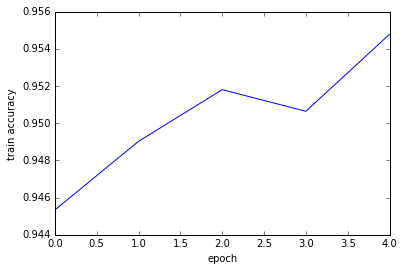

In [16]:
plt.plot(nnet_face.history['acc'])
plt.xlabel("epoch")
plt.ylabel("train accuracy")

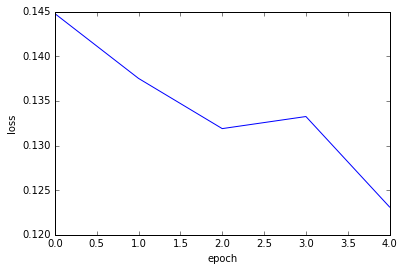

In [17]:
plt.plot(nnet_face.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

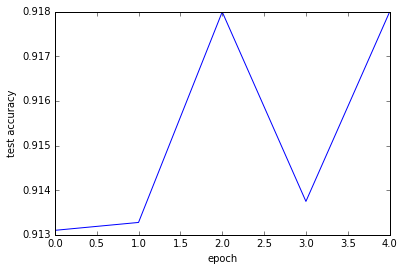

In [18]:
plt.plot(nnet_face.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("test accuracy")

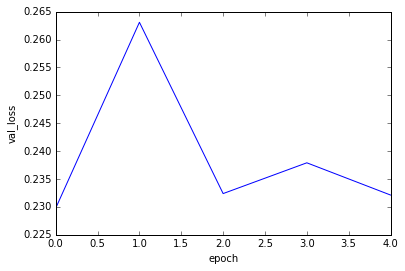

In [19]:
plt.plot(nnet_face.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("val_loss")

In [62]:
###tune learning rate
model2 = Model(inputs=base_model.input, outputs=predictions)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False
    
#change learning rate to 1e1-1   
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=0.05, momentum=0.9),
              metrics=['accuracy'])

In [63]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

# fine-tune the model
#increase epochs and add early stop
nnet_face2 = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=50,
                    verbose=1,
                    callbacks=[earlyStopping], 
                    validation_data=(x_test, y_test))

Train on 3597 samples, validate on 1542 samples
Epoch 1/50
3597/3597 [==============================] - 82s - loss: 0.2270 - acc: 0.9129 - val_loss: 0.2152 - val_acc: 0.9184

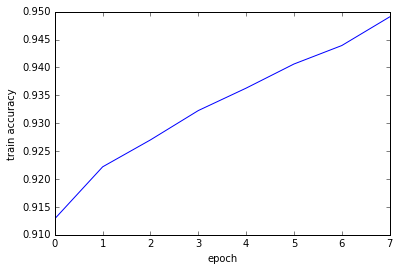

In [64]:
plt.plot(nnet_face.history['acc'])
plt.xlabel("epoch")
plt.ylabel("train accuracy")

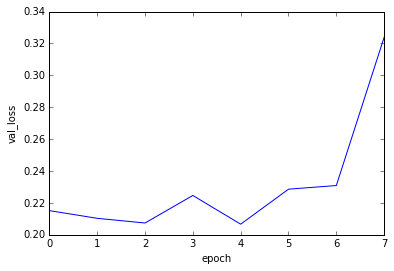

In [65]:
plt.plot(nnet_face.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("val_loss")